# July 17 Lab

In [1]:
# --- IMPORTS ---------------------------------------------------------------
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# --- OPTIONAL PLOT STYLE ---------------------------------------------------
plt.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

# --- HELPER FUNCTIONS ------------------------------------------------------
def plot_ecdf(data, ax=None, **kw):
    ec = ECDF(data)
    ax = ax or plt.gca()
    ax.step(ec.x, ec.y, where="post", **kw)
    ax.set_xlabel("Wait (min)")
    ax.set_ylabel("F_hat(x)")
    return ax

def aic(logL, k):
    return 2 * k - 2 * logL

def mean_from_params(dist_name, params):
    if dist_name == "gamma":
        a, loc, scale = params
        return loc + a * scale
    elif dist_name == "weibull_min":
        c, loc, scale = params
        return loc + scale * st.gamma(1 + 1 / c)
    elif dist_name == "lognorm":
        s, loc, scale = params
        return loc + scale * np.exp(s ** 2 / 2)
    else:
        return np.nan

In [2]:
# --- LOAD DATA -------------------------------------------------------------
df = pd.read_csv("mbta_wait_times.csv")
pre = df.loc[df.period == "PRE", "wait_min"].to_numpy()
post = df.loc[df.period == "POST", "wait_min"].to_numpy()
print(f"PRE n={pre.size}, mean={pre.mean():.2f} min")
print(f"POST n={post.size}, mean={post.mean():.2f} min")

PRE n=600, mean=3.85 min
POST n=650, mean=4.84 min


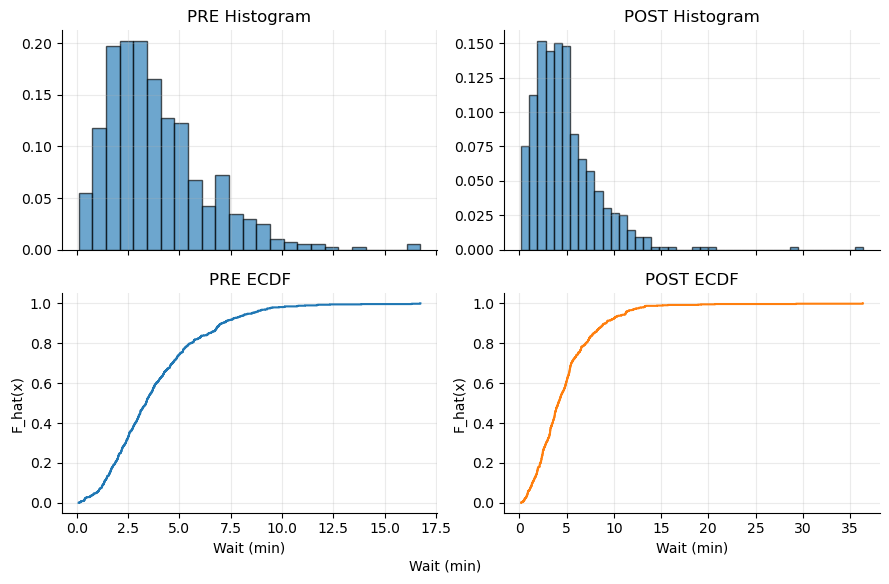

In [3]:
# --- VISUALIZATION: HIST + ECDF --------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(9, 6), sharex='col')

axs[0, 0].hist(pre, bins="auto", density=True, alpha=0.65, edgecolor="k")
axs[0, 0].set_title("PRE Histogram")
axs[0, 1].hist(post, bins="auto", density=True, alpha=0.65, edgecolor="k")
axs[0, 1].set_title("POST Histogram")

plot_ecdf(pre, ax=axs[1, 0], color="C0")
axs[1, 0].set_title("PRE ECDF")
plot_ecdf(post, ax=axs[1, 1], color="C1")
axs[1, 1].set_title("POST ECDF")

fig.text(0.5, 0.04, "Wait (min)", ha="center")
fig.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()


In [4]:
# --- MODEL SHORTLIST -------------------------------------------------------
candidates = {
    "gamma": st.gamma,
    "weibull_min": st.weibull_min,
    # optionally add: "lognorm": st.lognorm
}
print("Candidate models:", list(candidates))


Candidate models: ['gamma', 'weibull_min']


In [5]:
# --- FIT MODELS ------------------------------------------------------------
def fit_models(data, models):
    out = {}
    for name, dist in models.items():
        params = dist.fit(data)
        logL = dist.logpdf(data, *params).sum()
        k = len(params)
        out[name] = dict(params=params, logL=logL, k=k, AIC=aic(logL, k))
    return pd.DataFrame(out).T.sort_values("AIC")

fit_pre = fit_models(pre, candidates)
fit_post = fit_models(post, candidates)
print("PRE fits:"); display(fit_pre)
print("POST fits:"); display(fit_post)


PRE fits:


,params,logL,k,AIC
gamma,"(2.8330720359523776, -0.17588555964314997, 1.4...",-1297.451464,3,2600.902927
weibull_min,"(1.4548509669295906, 0.5989530214768142, 3.650...",-inf,3,inf


POST fits:


,params,logL,k,AIC
gamma,"(2.102145720176475, 0.08445217003943417, 2.262...",-1578.8265,3,3163.653
weibull_min,"(1.1796449365987804, 0.1889757828003762, 3.582...",-1653.884507,3,3313.769013


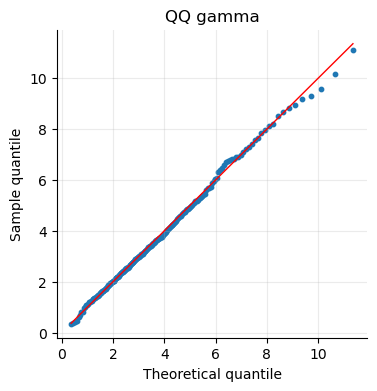

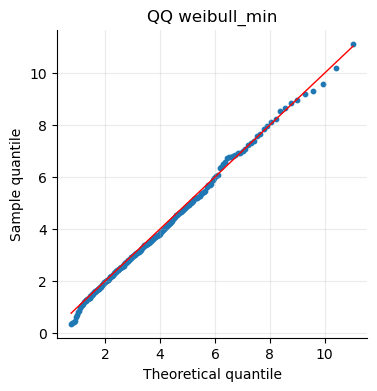

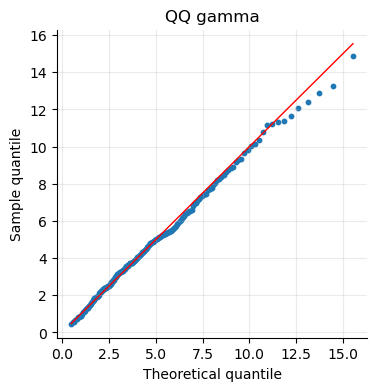

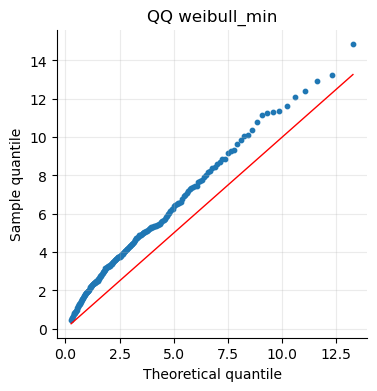

In [6]:
# --- QQ PLOTS --------------------------------------------------------------
def qq_compare(data, fit_tbl, models, probs=np.linspace(0.01, 0.99, 200)):
    qs = np.quantile(data, probs)
    for name in fit_tbl.index:
        dist = models[name]
        params = fit_tbl.loc[name, "params"]
        qt = dist.ppf(probs, *params)
        plt.figure(figsize=(4, 4))
        plt.scatter(qt, qs, s=10)
        plt.plot(qt, qt, 'r', lw=1)
        plt.title(f"QQ {name}")
        plt.xlabel("Theoretical quantile")
        plt.ylabel("Sample quantile")
        plt.show()

qq_compare(pre, fit_pre, candidates)
qq_compare(post, fit_post, candidates)


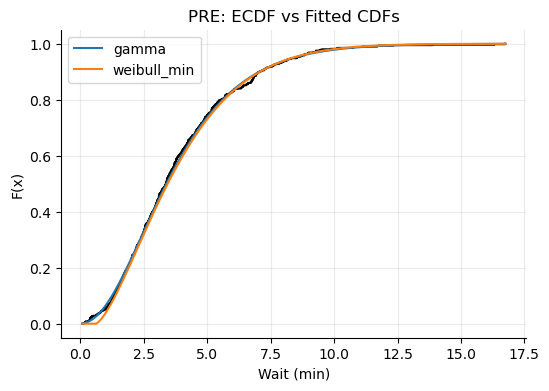

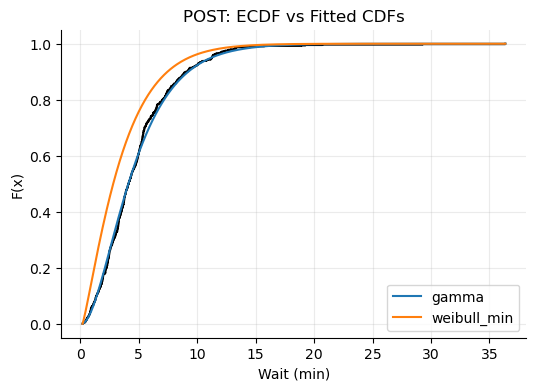

In [7]:
# --- CDF OVERLAY -----------------------------------------------------------
def cdf_overlay(data, fit_tbl, models, title):
    plt.figure(figsize=(6, 4))
    plot_ecdf(data, color="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name, "params"]
        plt.plot(xx, dist.cdf(xx, *pars), label=name)
    plt.legend(); plt.title(title)
    plt.xlabel("Wait (min)")
    plt.ylabel("F(x)")

cdf_overlay(pre, fit_pre, candidates, title="PRE: ECDF vs Fitted CDFs")
cdf_overlay(post, fit_post, candidates, title="POST: ECDF vs Fitted CDFs")

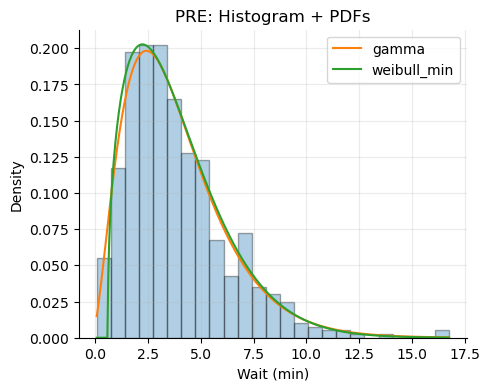

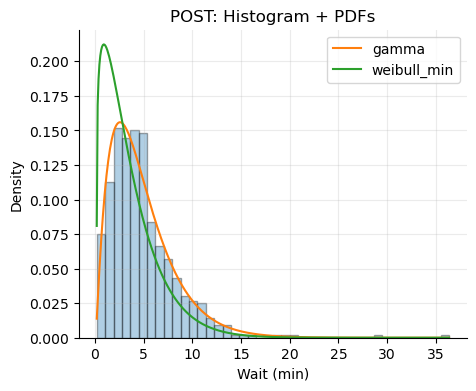

In [8]:
# --- PDF OVERLAY -----------------------------------------------------------
def pdf_overlay(data, fit_tbl, models, title):
    plt.figure(figsize=(5, 4))
    plt.hist(data, bins="auto", density=True, alpha=0.35, edgecolor="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name, "params"]
        plt.plot(xx, dist.pdf(xx, *pars), label=name)
    plt.legend(); plt.title(title)
    plt.xlabel("Wait (min)")
    plt.ylabel("Density")

pdf_overlay(pre, fit_pre, candidates, "PRE: Histogram + PDFs")
pdf_overlay(post, fit_post, candidates, "POST: Histogram + PDFs")


In [9]:
# --- BEST MODELS AND PRACTICAL SLOWDOWN -----------------------------------
best_pre = fit_pre.index[0]
best_post = fit_post.index[0]

mu_pre = mean_from_params(best_pre, fit_pre.loc[best_pre, "params"])
mu_post = mean_from_params(best_post, fit_post.loc[best_post, "params"])

delta = mu_post - mu_pre
ratio = mu_post / mu_pre

print(f"Best PRE model: {best_pre} mean={mu_pre:.2f} min")
print(f"Best POST model: {best_post} mean={mu_post:.2f} min")
print(f"Change POST-PRE: {delta:+.2f} min ({ratio:.2f}×)")


Best PRE model: gamma mean=3.85 min
Best POST model: gamma mean=4.84 min
Change POST-PRE: +0.99 min (1.26×)
